In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [24]:
movies=pd.read_csv('/content/movies.csv')
tags=pd.read_csv('/content/tags.csv')
ratings=pd.read_csv('/content/ratings.csv')

In [25]:
#limit ratings to user ratings that have rated more than 55 movies --
#otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

#list the movie titles that survive the filtering
movie_list_rating=ratings_f.movieId.unique().tolist()

In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
ratings.head()

In [28]:
#limit ratings to user ratings that have rated more than 55 movies --
#otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

#list the movie titles that survive the filtering
movie_list_rating=ratings_f.movieId.unique().tolist()

In [16]:
movies['genres']=movies['genres'].str.replace('|',' ')

<ipython-input-16-53f782c7a614>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres']=movies['genres'].str.replace('|',' ')


In [17]:
len(movies.movieId.unique())

9742

In [20]:
Mapping_file= dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [22]:
#create a mixed dataframe of movies title, genres
#and all user tags given to each movie
mixed=pd.merge(movies, tags,on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun


In [23]:
mixed.fillna("",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final=pd.merge(movies, mixed, on='movieId', how='left')
Final['metadata']=Final[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


In [29]:
# we have kept 98.8% of the original movie title in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

98.7990145760624

In [30]:
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100


59.67213114754099

In [31]:
movies=movies[movies.movieId.isin(movie_list_rating)]

In [32]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [33]:
#map movie to id
Mapping_file= dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [34]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1,inplace=True)

<ipython-input-34-069004ad8c44>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tags.drop(['timestamp'],1, inplace=True)
<ipython-input-34-069004ad8c44>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ratings_f.drop(['timestamp'],1,inplace=True)


In [35]:
#create a mixed dataframe of movies title, genres
#and all user tags given to each movie
mixed=pd.merge(movies, tags,on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun


In [36]:
# create metadata from tags and genres
mixed.fillna("",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final=pd.merge(movies, mixed, on='movieId', how='left')
Final['metadata']=Final[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure|Animation|Children|C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy|Romance


In [37]:
#Term frequency and inverse document frequency

# Purpose of Tf-idf is to highlight words which are frequent in a document but not across documents

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


In [38]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


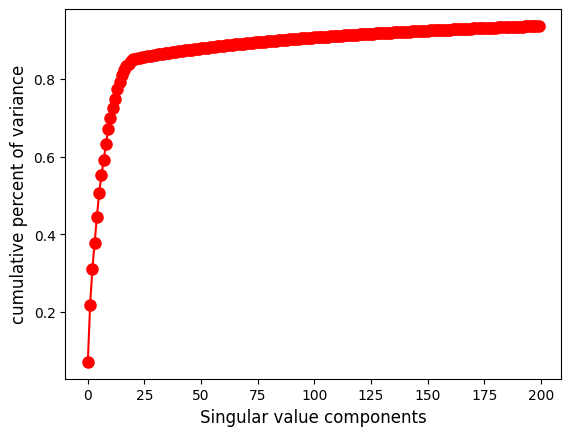

In [39]:
# Compress with SVD (singular value decomposition)
# SVD works very well for the sparse matrix
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components', fontsize=12)
plt.ylabel('cumulative percent of variance', fontsize=12)
plt.show()

In [40]:
#number of latent dimensions to keep
n=200
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [41]:
# our content latent matrix:
latent_matrix.shape

(9625, 200)

In [42]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [43]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on='movieId', how='right')

In [44]:
ratings_f1

,movieId,userId,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0
...,...,...,...
92724,166534,610,4.0
92725,168248,610,5.0
92726,168250,610,5.0
92727,168252,610,5.0


In [45]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns='userId', values = 'rating').fillna(0)

In [46]:
ratings_f2.head(3)

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [47]:
ratings_f2.shape

(9625, 364)

In [48]:
len(ratings_f.movieId.unique())

9625

In [49]:
from sklearn.decomposition import TruncatedSVD
scd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=Final.title.tolist())

In [50]:
latent_matrix_2_df.shape

(9625, 200)

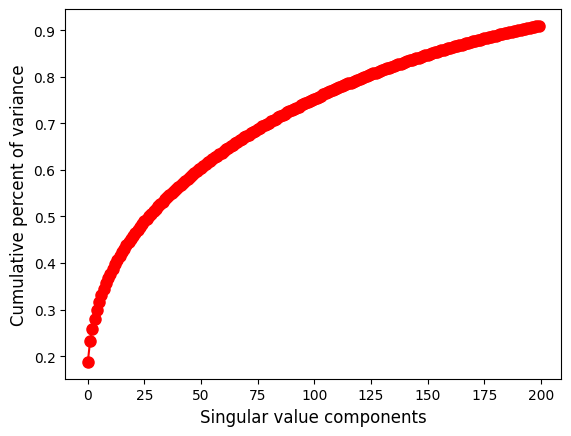

In [51]:
#plot variance explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms=16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [52]:
#This is my content matrix.
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,0.120142,-0.067836,0.019699,0.041242,0.123080,-0.058420,0.037135,-0.007993,-0.030467,0.083226
Jumanji (1995),0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,0.003012,0.011754,0.003479,-0.007153,0.003914,-0.014367,0.005671,0.018706,-0.012240,0.011761
Grumpier Old Men (1995),0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,-0.000691,-0.001002,-0.001880,0.003490,-0.003700,0.006584,0.001148,-0.003298,0.000327,-0.003501
Waiting to Exhale (1995),0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,-0.046063,0.001273,0.028399,-0.000377,...,-0.000142,-0.000071,0.000025,-0.000467,-0.000158,-0.000047,0.000180,-0.000037,-0.000407,-0.000218
Father of the Bride Part II (1995),0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,-0.009221,-0.001934,0.004463,-0.011439,...,0.009787,-0.005093,0.005222,-0.004658,-0.008953,0.007223,0.004543,-0.000987,-0.004268,0.000892


In [53]:
latent_matrix_2_df.head()


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),36.391240,-4.958788,14.331820,1.844157,-3.077922,-1.351171,8.341427,-0.561088,-1.898201,1.657858,...,0.624916,-2.776888,-0.070204,2.385175,-1.686798,-0.946708,-0.342125,0.895912,-2.514754,-1.254209
Jumanji (1995),20.447499,0.675231,11.354479,-7.325453,-3.505242,3.585611,4.393396,-5.564559,0.434472,0.351436,...,1.242177,1.107884,0.681338,0.486417,-1.394876,0.480116,-0.554044,-2.507810,-0.163917,-0.494263
Grumpier Old Men (1995),8.407816,-5.190801,4.378314,-6.189039,-0.333121,1.924149,-1.548363,0.795946,-3.196045,2.121790,...,-0.372031,-0.870387,-0.549502,0.117197,-0.473827,0.599235,-0.643893,0.420225,1.670766,0.459876
Waiting to Exhale (1995),0.408037,-0.664700,0.739903,-0.202676,-0.498374,1.055409,0.184081,-0.508293,-0.429505,0.086538,...,0.057684,0.310671,0.031670,0.089214,0.287495,0.036976,-0.259032,-0.060942,-0.384455,-0.040659
Father of the Bride Part II (1995),5.755079,-1.757369,3.961287,-3.673278,-3.688047,3.237858,1.140585,-0.690786,-2.171826,1.365963,...,-0.394551,0.900768,0.383074,-0.076478,0.500078,0.560373,-0.285218,-0.129149,0.809701,-0.064030


In [54]:
from sklearn.metrics.pairwise import cosine_similarity
#take the latent vectors for a selected movie from both content and collaborative matrixes
a_1=np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)
a_2=np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1,-1)

#calculate the similarity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

#an avg measure of both content and collaborative
hybrid = ((score_1 + score_2)/2.0)

#form a data frame of similar movies
dictDf = {'content': score_1, 'collaborative':score_2, 'hybrid':hybrid}
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)

#sort it on the basis of either: content, collaborative or hybrid,
#here : content
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)


,content,collaborative,hybrid
"Bug's Life, A (1998)",0.896629,0.591238,0.743934
Toy Story 2 (1999),0.776450,0.685465,0.730958
Shrek (2001),0.411477,0.668752,0.540114
"Monsters, Inc. (2001)",0.441020,0.607929,0.524474
Up (2009),0.553485,0.430128,0.491807
Antz (1998),0.441020,0.443938,0.442479
Aladdin (1992),0.240911,0.639349,0.440130
Ice Age (2002),0.386531,0.481035,0.433783
Toy Story 3 (2010),0.361495,0.501299,0.431397
Who Framed Roger Rabbit? (1988),0.359694,0.498098,0.428896
